In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/ML_CUONG/NLP

/content/drive/My Drive/ML_CUONG/NLP


In [93]:
# import thư viện
!pip install pyvi
!pip install tqdm
import json
import random
import os
import glob
from random import randint 
from gensim import corpora, matutils
import pickle as cPickle   
from pyvi import ViTokenizer 
from tqdm import trange, tqdm_notebook
import numpy as np
from past.builtins import xrange
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder

In [0]:
# tạo class đọc file 
class FileReader(object):
    def __init__(self, file_path, encoder = None):
        self.file_path = file_path
        self.encoder = encoder if encoder != None else 'utf-16le'

    def read(self):
        with open(self.file_path,'rb') as f:
            s = f.read() 
        return s

    def content(self):
        s = self.read() 
        return s.decode(self.encoder)

    def read_json(self):
        with open(self.file_path) as f:
            s = json.load(f)
        return s
        
    def read_stopwords(self):
        with open(self.file_path, 'r') as f:
            stopwords = set([w.strip().replace(' ', '_') for w in f.readlines()])
        return stopwords

    def load_dictionary(self):
        return corpora.Dictionary.load_from_text(self.file_path)


In [0]:
DATA_TRAIN_PATH = '/content/drive/My Drive/ML_CUONG/NLP/dataset/TRAIN_FULL' 
DATA_TRAIN_JSON = '/content/drive/My Drive/ML_CUONG/NLP/dataset/json/train.json'

STOP_WORDS = '/content/drive/My Drive/NLP/nlp_me/stopwords-nlp-vi.txt'
SPECIAL_CHARACTER = '0123456789%@$.,=+-!;/()*"&^:#|\n\t\''
DICTIONARY_PATH = '/content/drive/My Drive/ML_CUONG/NLP/dataset/json/dictionary_IR.txt'

In [0]:
# tạo class load dữ liệu từ thư mục cho trước theo format Main Directory/Country/Aspect/... .txt
class DataLoader(object):
    def __init__(self, dataPath):
        self.dataPath = dataPath

    def __get_files(self):  
        folders = [self.dataPath +'/'+ folder + '/' for folder in os.listdir(self.dataPath)]
        print(folders)
        for item in folders:
            print(item)
        class_titles = os.listdir(self.dataPath)
        files = {}
        for folder, title in zip(folders, class_titles):
            if folder.split('/')[-2] == '.DS_Store':
                continue
            files[title] = [folder + f for f in os.listdir(folder)]
        self.files = files
        print(self.files) 
 
    def get_json(self):
        self.__get_files()
        data = []
        for topic in self.files:
            print(topic)
            for index in tqdm_notebook(xrange(len(self.files[topic])), desc='build dictionary'):  
                # rand = randint(1000,1200)
                # i = 0
                file = self.files[topic][index]
                paths = glob.glob(file+"/*.txt")
                if file.split('/')[-2] == 'Chau_au':
                    paths = glob.glob(file+"/*/*.txt") 
                for index, path in enumerate(paths): 
                    try:
                      content = FileReader(file_path=path).content() 
                    except:
                      continue
                    data.append({
                        'category': '.'.join([path.split('/')[-2]]),
                        'content': content
                    }) 
                    
                    # if i == rand:
                    #     break
                    # else:
                    #     i += 1  
        return data

class FileStore(object):
    def __init__(self, file_path, data = None):
        self.file_path = file_path
        self.data = data

    def store_json(self):
        print("Save: ",self.file_path)
        with open(self.file_path, 'w') as outfile:
            json.dump(self.data, outfile)

    # store dictionary: https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes
    # dict_word là mãng chữa các đoạn text đã được segmentation [[cá, con, ăn],[con, mèo],[con, chó, chạy, qua]]
    # len của dictionary sẽ là 7 
    # no_above là tần suất xuất hiện trên số phần trăm ví dụ: no_above = 0.5 là tần suất xuất hiện không được trên (phải dưới) của tổng số tài liệu 50%
    # no_below là số lần xuất hiện không được dưới ... ví dụ no_below = 2 là số lần xuất hiện trong từng tài liệu không được dưới 2
    def store_dictionary(self, dict_words):
        dictionary = corpora.Dictionary(dict_words)
        dictionary.filter_extremes(no_below=50, no_above=0.3) 
        dictionary.save_as_text(self.file_path)
 

    def save_pickle(self,  obj):
        outfile = open(self.file_path, 'wb')
        fastPickler = cPickle.Pickler(outfile, 4)
        fastPickler.fast = 1
        fastPickler.dump(obj)
        outfile.close()



In [83]:
# ví dụ về library 
corpus = [["máma", "mele", "maso",'aa','aa'], ["ema",'aa', "má", "maso"],['maso','aa','aa','aa','aa','aa','aa','aa'], ["ema", "má", "máma"]]
dct = corpora.Dictionary(corpus)
dct.filter_extremes(no_below=3, no_above=0.76, keep_n=1000000)
print(dct)

# vì từ maso xuất hiện 3 lần (trên 2 lần) và chiểm 3 trên 4 tổng số tài liệu 3/4 = 0.75 lớn hơn 0.74 nên không tồn tài trong dictionary
# vì từ máma xuất hiện 2 lần (= 2 lần) và chiếm 2 trên 4 tổng số tài liệu 2/4= 0.5 nhỏ hơn 0.74 nên vần còn trong dic 
# vì từ ema xuất hiện 2 lần (= 2 lần) và chiếm 2 trên 4 tổng số tài liệu 2/4= 0.5 nhỏ hơn 0.74 nên vần còn trong dic 
# vì từ aa xuất hiện 7 lần (trong 1 doc) nhưng 1 lần/1 doc (dưới 2 lần) nên không còn trong dic 


Dictionary(2 unique tokens: ['aa', 'maso'])


In [0]:
# # # # lấy đường dẫn thư mục làm label và nội dung làm dữ liệu theo format {category: '',content,''}
# json_train = DataLoader(dataPath=DATA_TRAIN_PATH).get_json()

# # # # lưu file train
# FileStore(file_path=DATA_TRAIN_JSON, data=json_train).store_json()
# print('Total data train: %d' %len(json_train))

In [94]:
# đọc file train
train_loader = FileReader(file_path=DATA_TRAIN_JSON) 
data_train = train_loader.read_json()
print('Total data train: %d' %len(data_train))
random.shuffle(data_train)

Total data train: 16215


In [0]:
# xây dựng class NLP extends từ pyvi để extract feature 
class NLP(object):
    def __init__(self, text = None):
        self.text = text
        self.__set_stopwords()

    #đọc file stop_word đã chứa sẵn trong đường dẫn
    def __set_stopwords(self):
        self.stopwords = FileReader(STOP_WORDS).read_stopwords()

    # vì trong câu sẽ xuất hiện rất nhiều từ vô nghĩa, sẽ làm noise dữ liệu cho nên phải segmentation trước khi train. Sử dụng ViTokenizer từ Pyvi 
    # để tokenize (đây là một model do người việt đã làm để segmentation tiếng việt)
    def segmentation(self):
        return ViTokenizer.tokenize(self.text)

    # loại bỏ kí tự đặc biệt, lowercase và segmentation tiếng việt
    def split_words(self):
        text = self.segmentation()
        try:
            return [x.strip(SPECIAL_CHARACTER).lower() for x in text.split()]
        except TypeError:
            return []

    # get feature trong câu gồm hai bước 
    # loại bỏ kí tự đặc biệt và loại bỏ stop_words - stop_word là những từ vô nghĩa không mang lại hiệu quả train 
    def get_words_feature(self):
        split_words = self.split_words()
        return [word for word in split_words if word.encode('utf-8') not in self.stopwords]


In [0]:
# extract feature 
# build dictionary để chuyển embedding dữ liệu, chuyển về word2vec => bag of word
from past.builtins import xrange
class FeatureExtraction(object):
    def __init__(self, data=None, build_dic=False):
        self.data = data
        self.build_dic = build_dic

    # build từ điển gồm các từ xuất hiện trong văn bản sau khi đã preprocess dữ liệu 
    def __build_dictionary(self):
        print('Building dictionary')
        dict_words = []  
        for i in tqdm_notebook(xrange(len(self.data)), desc='build dictionary'): 
          if self.data[i]['category'].split('.')[0] != 'My': 
            words = NLP(text = self.data[i]['content']).get_words_feature()
            dict_words.append(words)  
        FileStore(file_path=DICTIONARY_PATH).store_dictionary(dict_words)

    # load từ điển đã xây dựng theo dữ liệu train
    def __load_dictionary(self):
        if os.path.exists(DICTIONARY_PATH) == False or self.build_dic == True: 
            print("Dictionary is not exist")
            self.__build_dictionary() 
            self.build_dic = False
        
        self.dictionary = FileReader(DICTIONARY_PATH).load_dictionary()
    # extract feature từ từ điển đã tạo cùng với label
    # x sẽ là word2vec, y là label
    def __build_dataset(self):
        self.features = []
        self.labels = [] 
        for i in tqdm_notebook(xrange(len(self.data)), desc='build dataset'): 
            if self.data[i]['category'].split('.')[0] != 'My': 
              content = self.get_dense(self.data[i]['content'])
              self.features.append(content)
              self.labels.append(self.data[i]['category'])
              # if str(self.data[i]['category'].split('.')[1]) == 'Chinh_tri_doi_ngoai' or str(self.data[i]['category'].split('.')[1]) == 'Chinh_tri_noi_bo':
              #   self.labels.append(str(self.data[i]['category'].split('.')[0])+'.Chinh_tri')
              # else:
              #   self.labels.append(str(self.data[i]['category'].split('.')[0])+'.'+str(self.data[i]['category'].split('.')[1]))

    def get_dense(self, text):
        self.__load_dictionary()
        words = NLP(text).get_words_feature()
        # Bag of words
        vec = self.dictionary.doc2bow(words)  
        dense = list(matutils.corpus2dense([vec], num_terms=len(self.dictionary)).T[0])
        return dense

    def get_data_and_label(self):
        print("** Start build dataset")
        self.__build_dataset()  
        return self.features, self.labels



In [96]:
 # build_dic là biến để biết build dictionary hay không ? 
# extract feature từ model của pyvi để build data set
# print(data)
features_train, labels_train = FeatureExtraction(data=data_train, build_dic=False).get_data_and_label() 

# a = FeatureExtraction(data=data_train, build_dic=False)
# b = a.get_dense("MacBook Air là dòng laptop mỏng nhẹ lần đầu ra mắt vào năm 2007. Thiết kế được nâng cấp của MacBook Air năm 2010 nhanh chóng trở thành \"chuẩn mực\" mà mãi đến 5 năm sau các hãng laptop Windows mới đuổi kịp (khái niệm ultrabook).")
# FileReader(DICTIONARY_PATH).load_dictionary().num_docs


** Start build dataset


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


In [0]:
# load data hơi lâu nên để hai biến giữ lại data ban dầu 
# a, b = np.array(features_train),np.array(labels_train) 
x, y = np.array(features_train),np.array(labels_train)
 

In [0]:
from keras.utils import to_categorical

# encode label 
mlb = LabelEncoder() 
k = mlb.fit_transform(y)
# one hot encoding 
y = to_categorical(k)

In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X_draw = TSNE(n_components=2).fit_transform(x[:2000]) 

No handles with labels found to put in legend.


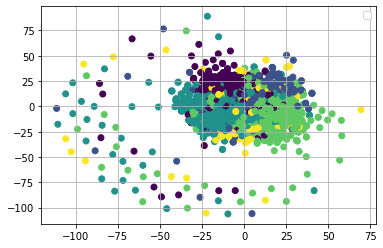

In [137]:
plt.scatter(X_draw[:,0],X_draw[:,1],c=k[:2000])
plt.legend()
plt.grid(True)

In [0]:
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2).fit(np.array(x))
X_draw_PCA = pca.transform(x)

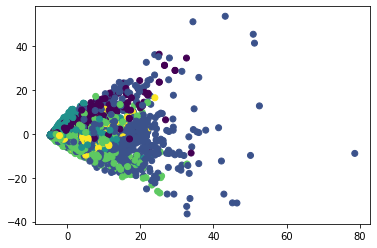

In [133]:
plt.scatter(X_draw_PCA[:,0],X_draw_PCA[:,1],c=k) 

In [138]:
from sklearn.model_selection import train_test_split
# chia tập train, test theo tỉ lệ 8:2  

(x_train,x_test, y_train, y_test) = train_test_split(x, y, test_size=0.2, random_state=43)
y_train.shape

(12972, 5)

In [139]:
print('Shape features:',"Total document",y_train.shape[0] + y_test.shape[0],"- Size matrix train (size dictionary)",x_train.shape)
print('Train set',y_train.shape[0],'docs') 
print('Test set',y_test.shape[0],'docs') 
print("Shape",x.shape,y.shape)
SIZE_TRAIN = x_train.shape[1]
y_test[0]


Shape features: Total document 16215 - Size matrix train (size dictionary) (12972, 4397)
Train set 12972 docs
Test set 3243 docs
Shape (16215, 4397) (16215, 5)


array([1., 0., 0., 0., 0.], dtype=float32)

In [140]:
print("- tổng số label:")
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label)) 

- tổng số label:
1. Du_lich
2. Giao_duc
3. Khoa_hoc
4. Phap_luat
5. Thoi_su


In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.optimizers import Adam, SGD 
from keras.layers import LeakyReLU
from sklearn.metrics import classification_report
# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras import Sequential

# xây dựng mạng network
class ModelNLP(object):
  @staticmethod
  def build(SIZE_TRAIN,num_classes, final_activation):
    model = Sequential()
    model.add(Dense(500, input_shape=(SIZE_TRAIN,), activation='tanh', kernel_initializer="uniform")) 
    model.add(LeakyReLU(alpha=0.3))        
    model.add(Dropout(rate=0.2)) 
    model.add(Dense(400))      
    model.add(LeakyReLU(alpha=0.3))  
    model.add(Dropout(rate=0.2)) 
    model.add(Dense(300))      
    model.add(LeakyReLU(alpha=0.3))        
    model.add(Dropout(rate=0.2))
    model.add(Dense(200))      
    model.add(Dense(num_classes, activation=final_activation))
  
    return model


In [149]:
# !pip install tensorflow==1.14
# khởi tạo model
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

model = ModelNLP.build(SIZE_TRAIN=SIZE_TRAIN,num_classes=len(mlb.classes_),final_activation='softmax')
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
sgd = SGD(lr=0.001); 
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 500)               2199000   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 500)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 400)               200400    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 400)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)              

In [150]:
# training 
H = model.fit(x_train, y_train, validation_data= (x_test,y_test),epochs=100, verbose=1)

Train on 12972 samples, validate on 3243 samples
Epoch 1/100
12972/12972 [==============================] - 2s 144us/step - loss: 0.5045 - accuracy: 0.7980 - val_loss: 0.4809 - val_accuracy: 0.8000
Epoch 2/100
12972/12972 [==============================] - 2s 132us/step - loss: 0.4774 - accuracy: 0.7993 - val_loss: 0.4581 - val_accuracy: 0.8007
Epoch 3/100
12972/12972 [==============================] - 2s 133us/step - loss: 0.4553 - accuracy: 0.8030 - val_loss: 0.4376 - val_accuracy: 0.8051
Epoch 4/100
12972/12972 [==============================] - 2s 130us/step - loss: 0.4361 - accuracy: 0.8082 - val_loss: 0.4175 - val_accuracy: 0.8113
Epoch 5/100
12972/12972 [==============================] - 2s 130us/step - loss: 0.4170 - accuracy: 0.8164 - val_loss: 0.3974 - val_accuracy: 0.8214
Epoch 6/100
12972/12972 [==============================] - 2s 130us/step - loss: 0.3972 - accuracy: 0.8273 - val_loss: 0.3772 - val_accuracy: 0.8327
Epoch 7/100
12972/12972 [==============================] 

In [151]:
# evaluate 
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100)) 

Test Accuracy: 96.737593


In [0]:
LABEL_ENCODE_PATH="/content/drive/My Drive/ML_CUONG/NLP/model/mlb.pkl"
ESTIMATE_PATH="/content/drive/My Drive/ML_CUONG/NLP/model/estimator.h5"
FileStore(file_path=LABEL_ENCODE_PATH).save_pickle(obj=mlb)
FileStore(file_path=ESTIMATE_PATH).save_pickle(obj=model)

from keras.models import save_model, load_model

# Creates a HDF5 file 'ESTIMATE_PATH.h5' 
save_model(model, ESTIMATE_PATH)

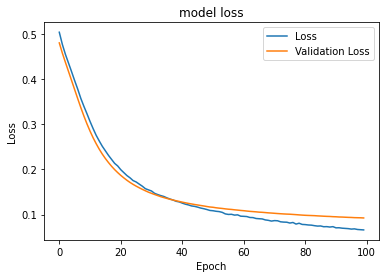

<Figure size 432x288 with 0 Axes>

In [153]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

In [154]:
# print(x_test.shape)
print("[INFO] classifying...")
# print(x_test[221].shape)
# print(y_test[221])
proba = model.predict(x_test)[221]
print(proba)
idxs = np.argsort(proba)[::-1] 
# loop over the indexes of the high confidence class labels
 
for (i, j) in enumerate(idxs):
	# build the label and draw the label on the image
	label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100) 

# show the probabilities for each of the individual labels
for (label, p) in zip(mlb.classes_, proba): 
	print("{}: {:.2f}%".format(label, p * 100, p))
 

[INFO] classifying...
[5.29506178e-06 1.07348395e-04 6.59088244e-07 9.87287045e-01
 1.25996126e-02]
Du_lich: 0.00%
Giao_duc: 0.01%
Khoa_hoc: 0.00%
Phap_luat: 98.73%
Thoi_su: 1.26%


(12972,)

 TF-IDF LINEAR SVC 

In [0]:
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import time 
from sklearn import metrics
from sklearn import svm 
from sklearn.svm import SVC

In [31]:
# đọc file train
train_loader = FileReader(file_path=DATA_TRAIN_JSON) 
data_train = train_loader.read_json()
print('Total data train: %d' %len(data_train))

Total data train: 16215


In [0]:
X, y = [], []
for item in data_train:
  X.append(item['content'])
  y.append(item['category'])

file_sw = FileReader(STOP_WORDS).read_stopwords()
# [word for word in split_words if word.encode('utf-8') not in self.stopwords] 
stop_word = [char for char in SPECIAL_CHARACTER]
for item in file_sw:
  words = item.split('_')
  if len(words) > 1:
    stop_word.extend(words)
  else:
    stop_word.append(item)
vectorizer = TfidfVectorizer(stop_words=stop_word)
X_train = vectorizer.fit_transform(X) 

In [0]:
(x_train,x_test, y_train, y_test) = train_test_split(X_train, np.array(y), test_size=0.2, random_state=42)

In [34]:
print('Shape features:',"Total document",y_train.shape[0] + y_test.shape[0],"- Size matrix train (size dictionary)",x_train.shape)
print('Train set',y_train.shape[0],'docs') 
print('Test set',y_test.shape[0],'docs') 
print("Shape",x_train.shape,x_test.shape)
SIZE_TRAIN = x_train.shape[1] 

Shape features: Total document 16215 - Size matrix train (size dictionary) (12972, 31422)
Train set 12972 docs
Test set 3243 docs
Shape (12972, 31422) (3243, 31422)


In [35]:
# ví dụ về sử dụng Linear SVC
svm_classifier = LinearSVC(random_state=42, tol=1e-5)
svm_classifier.fit(X=x_train,y=y_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=1e-05,
          verbose=0)

In [36]:
from sklearn.metrics import classification_report
# predict
y_pred_svm = svm_classifier.predict(x_test)
print('predict:\n',y_pred_svm)
print(classification_report(y_test,y_pred_svm))

# tính accuracy 
acc_score_svm = metrics.accuracy_score(y_pred_svm,y_test) 
print('accuracy:\n',acc_score_svm) 

predict:
 ['Phap_luat' 'Khoa_hoc' 'Du_lich' ... 'Du_lich' 'Phap_luat' 'Du_lich']
              precision    recall  f1-score   support

     Du_lich       0.92      0.93      0.92       537
    Giao_duc       0.92      0.85      0.88       480
    Khoa_hoc       0.94      0.98      0.96       966
   Phap_luat       0.94      0.96      0.95       960
     Thoi_su       0.87      0.81      0.84       300

    accuracy                           0.93      3243
   macro avg       0.92      0.90      0.91      3243
weighted avg       0.93      0.93      0.93      3243

accuracy:
 0.9290780141843972


 COUNT LINEAR SVC 

In [0]:
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import time 
from sklearn import metrics
from sklearn import svm 

In [52]:
# đọc file train
train_loader = FileReader(file_path=DATA_TRAIN_JSON) 
data_train = train_loader.read_json()
print('Total data train: %d' %len(data_train))


Total data train: 16215


In [0]:

X, y = [], []
for item in data_train:
  X.append(item['content'])
  y.append(item['category'])

file_sw = FileReader(STOP_WORDS).read_stopwords()
# [word for word in split_words if word.encode('utf-8') not in self.stopwords] 
stop_word = [char for char in SPECIAL_CHARACTER]
for item in file_sw:
  words = item.split('_')
  if len(words) > 1:
    stop_word.extend(words)
  else:
    stop_word.append(item)  
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X)

In [0]:
(x_train,x_test, y_train, y_test) = train_test_split(X_train, np.array(y), test_size=0.2, random_state=42)

In [41]:
# ví dụ về sử dụng Linear SVC
svm_classifier = svm.LinearSVC(random_state=42, tol=1e-5)
svm_classifier.fit(X=x_train,y=y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=1e-05,
          verbose=0)

In [42]:
from sklearn.metrics import classification_report
# predict
y_pred_svm = svm_classifier.predict(x_test)
print('predict:\n',y_pred_svm)
print(classification_report(y_test,y_pred_svm))

# tính accuracy 
acc_score_svm = metrics.accuracy_score(y_pred_svm,y_test) 
print('accuracy:\n',acc_score_svm) 

predict:
 ['Phap_luat' 'Khoa_hoc' 'Du_lich' ... 'Du_lich' 'Phap_luat' 'Du_lich']
              precision    recall  f1-score   support

     Du_lich       0.92      0.92      0.92       537
    Giao_duc       0.92      0.89      0.91       480
    Khoa_hoc       0.96      0.97      0.96       966
   Phap_luat       0.94      0.95      0.95       960
     Thoi_su       0.81      0.80      0.80       300

    accuracy                           0.93      3243
   macro avg       0.91      0.91      0.91      3243
weighted avg       0.93      0.93      0.93      3243

accuracy:
 0.9284613012642615


TRAIN COUNT - TF-IDF LINEAR SVC 

In [43]:
# đọc file train
train_loader = FileReader(file_path=DATA_TRAIN_JSON) 
data_train = train_loader.read_json()
print('Total data train: %d' %len(data_train))


Total data train: 16215


In [44]:
print(data_train[10])
print(data_train[3000])
print(data_train[12000]) 

{'category': 'Du_lich', 'content': 'Chính phủ đề xuất tiếp tục cấp visa điện tử thêm hai năm\n\nSáng 5/11,\xa0\n\xa0từ tháng 2/2017 đến tháng 10/2018, Bộ Công an đã cấp 336.932 thị thực điện tử. \nĐể bảo đảm hoạt động cấp thị thực điện tử cho người nước ngoài nhập cảnh Việt Nam không bị gián đoạn, không ảnh hưởng đến đối ngoại, Chính phủ kiến nghị Quốc hội cho phép kéo dài thời gian thực hiện thí điểm thêm 2 năm, kể từ ngày 1/2/2019.\xa0\nBộ trưởng Bộ Công an khẳng định, trong hai năm qua, chưa phát hiện người nước ngoài nhập cảnh bằng thị thực điện tử có hoạt động xâm phạm an ninh, quốc gia hoặc có vấn đề phức tạp về an ninh trật tự.\nKiến nghị trên được các đại biểu Quốc hội tán thành và Ủy ban Quốc phòng và An ninh (thuộc Quốc hội) nhất trí. Phó chủ tịch Quốc hội Đỗ Bá Tỵ cho biết, nội dung cho phép kéo dài thí điểm sẽ được quy định trong nghị quyết chung của kỳ họp thứ 6.\nViệt Nam đang thí điểm cấp visa điện tử cho công dân của 46 nước. Người nước ngoài được cấp thị thực điện tử c

In [0]:
X, y = [], []
for item in data_train:
  X.append(item['content'])
  y.append(item['category'])

In [0]:
from sklearn.model_selection import train_test_split
# chia tập train, test theo tỉ lệ 8:2
# load data hơi lâu nên để hai biến giữ lại data ban dầu 
# a, b = np.array(features_train),np.array(labels_train) 
x_arr, y_arr = np.array(X),np.array(y)
 
(x_train,x_test, y_train, y_test) = train_test_split(x_arr, y_arr, test_size=0.2, random_state=42) 

In [0]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import time
def grid_search(pipeline, X_train, y_train, X_test, y_test): 
    target_names = list(set([i[0] for i in y_train]))
    print("%d documents (training set)" % len(X_train))
    print("%d documents (test set)" % len(X_test))
    print("%d categories" % len(target_names))
    print()

    gridsearch = GridSearchCV(pipeline, parameters, cv=2,
                              n_jobs=-1, verbose=1)  
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time.time()
    gridsearch.fit(X_train, y_train)
    print("done in %0.3fs" % (time.time() - t0))
    print("Best dev score: %0.3f" % gridsearch.best_score_)
    print("Best parameters set:")
    best_parameters = gridsearch.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    print("Best test score: %0.3f" % gridsearch.score(X_test, y_test))


if __name__ == '__main__':
    print("Loading from dataset")

    pipeline_tfidf = Pipeline([
        ("vect", TfidfVectorizer()),
        ("clf", LinearSVC()),
    ])
    pipeline_count = Pipeline([
        ("vect", CountVectorizer()),
        ("clf", LinearSVC()),
    ])
    parameters = {
        'vect__max_df': (0.5, 0.6, 0.7, 0.8),
        'vect__ngram_range': ((1, 2), (1, 3)),
    }

    # if args.trans == "tfidf":
    grid_search(pipeline_tfidf, x_train, y_train, x_test, y_test)

    # # if args.trans == "count":
    # grid_search(pipeline_count, x_train, y_train, x_test, y_test)

Visualization


In [62]:
import random
# đọc file train
train_loader = FileReader(file_path=DATA_TRAIN_JSON) 
data_train = train_loader.read_json()
print('Total data train: %d' %len(data_train))

random.shuffle(data_train)


X, y = [], []
for item in data_train:
  X.append(item['content'])
  y.append(item['category'])

file_sw = FileReader(STOP_WORDS).read_stopwords()
# [word for word in split_words if word.encode('utf-8') not in self.stopwords] 
stop_word = [char for char in SPECIAL_CHARACTER]
for item in file_sw:
  words = item.split('_')
  if len(words) > 1:
    stop_word.extend(words)
  else:
    stop_word.append(item)  
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X)

# encode label 
mlb = LabelEncoder() 
y = mlb.fit_transform(y)

Total data train: 16215


In [0]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X_draw = TSNE(n_components=2).fit_transform(X_train[:500]) 

No handles with labels found to put in legend.


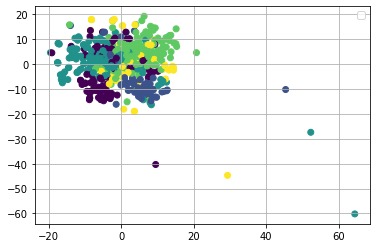

In [78]:
plt.scatter(X_draw[:,0],X_draw[:,1],c=y[:500])
plt.legend()
plt.grid(True)

In [0]:
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
import matplotlib.pyplot as plt
X_draw_PCA = PCA(n_components=2).fit(np.array(X_train[:1000])
plt.scatter(X_draw_PCA[:,0],X_draw_PCA[:,1],c=y[:1000], cmap="RdYlGn",label=['Du_lich','Giao_duc','Khoa_hoc','Phap_luat','Thoi_su'])
print(y)

In [0]:
print(x_test.shape)
print(y_test.shape)
# x = TSNE(n_components=2).fit_transform(features_test)
# plt.scatter(x[:,0],x[:,1],c=labels_test)

In [0]:
# TRAIN BY LinearSVC => output not multi

In [0]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
estimator = LinearSVC(verbose=1,random_state=42,tol=1e-05)

In [0]:
# chia tập train, test theo tỉ lệ 8:2
(x_train, x_test,y_train, y_test) = train_test_split(a, b, test_size=0.2, random_state=42)

In [0]:
print(y_test)

In [0]:
estimator.fit(x_train, y_train)

In [0]:
y_pred = estimator.predict(x_test) 
print(classification_report(y_test, y_pred)) 

#BERT

In [0]:
import os
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import torch
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import  tqdm_notebook
# !pip install pytorch_transformers
# from pytorch_transformers import *
import shutil
%cd /content/drive/My Drive/NLP/nlp_classifiication_bert

In [0]:
directory_path = '/content/drive/My Drive/NLP/nlp_classifiication_bert'## we will store our data in this drive

In [0]:
train_df = pd.read_csv(os.path.join(directory_path,'labeledTrainData.tsv'),delimiter='\t')
test_df = pd.read_csv(os.path.join(directory_path,'testData.tsv'),delimiter='\t')

In [0]:
train_df.shape,test_df.shape

In [0]:
train_df.head(n=2)

In [0]:
lm_df = pd.concat([train_df[['review']],test_df[['review']]])

In [0]:
lm_df.review = lm_df.review.str.lower()

In [0]:
train_df.review = train_df.review.str.lower()
sentences = train_df.review.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = train_df.sentiment.values

In [0]:
# %%time
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
# print ("Tokenize the first sentence:")


In [0]:
print(labels[:10])

In [0]:
# input_ids=[]
# for i in tqdm_notebook(range(len(tokenized_texts))):
#   input_ids.append(tokenizer.convert_tokens_to_ids(tokenized_texts[i]))

In [0]:
MAX_LEN = 256
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
input_ids[:10]

In [0]:
## Define model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device ='cpu'
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
model.to(device)

In [0]:
#Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,random_state=56, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=56, test_size=0.2)

In [0]:
#Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [0]:
lr = 2e-5
max_grad_norm = 1.0
num_total_steps = 1000
num_warmup_steps = 100
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  # 0.1


### In PyTorch-Transformers, optimizer and schedules are splitted and instantiated like this:
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [0]:
total_step = len(train_dataloader)
# Store our loss and accuracy for plotting
train_loss_set = []


epochs = 2

# trange is a tqdm wrapper around the normal python range
for epoch in tqdm_notebook(range(epochs)):
  
  

    # Training
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for i, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Forward pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss = outputs[0]
      train_loss_set.append(loss.item())    
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
      if (i) % 50 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.item()))

In [0]:
torch.save(model.state_dict(), directory_path+'/model_without_language_model.ckpt')

In [0]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(validation_dataloader):
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Forward pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      # print (outputs)
      prediction = torch.argmax(outputs[0],dim=1)
      total += b_labels.size(0)
      correct+=(prediction==b_labels).sum().item()

In [0]:
print('Test Accuracy of the model on val data is: {} %'.format(100 * correct / total)) 